## Performance evaluation: LLM-assisted Q&A

**Overview**: In this example, we will see how to use UpTrain to run openai evals. You can run any of the standard evals defined in the evals registry or create your custom one with custom prompts. We will use a Q&A task as an example to highlight both of them.

**Problem**: The workflow of our hypothetical Q&A application goes like this,
- User enters a question. 
- The query converts to an embedding, and relevant sections from the documentation are retrieved using nearest neighbour search. 
- The original query and the retrieved sections are passed to a language model (LM), along with a custom prompt to generate a response.  

Our goal is the evaluate the quality of the answer generated by the model using openai evals.

**Solution**: We illustrate how to use the Uptrain Evals framework to assess the chatbot's performance. We will use a dataset built from logs generated by a chatbot made to answer questions from the [Streamlit user documentation](https://docs.streamlit.io/). For model grading, we will use GPT-3.5-turbo with grading type as ['coqa-closedqa-correct'](https://github.com/openai/evals/blob/main/evals/registry/modelgraded/closedqa.yaml) as well as define our custom grading prompt for the same.

## Install UpTrain with all dependencies

```bash
pip install uptrain
uptrain-add --feature full
```

In [1]:
import os
import tempfile

import polars as pl

TEMP_DIR = tempfile.gettempdir()
UPTRAIN_LOGS_DIR = os.path.join(TEMP_DIR, "uptrain_logs_openai_eval")


**This notebook uses the OpenAI API to generate text for prompts, make sure the env variable is populated with the API key.**

In [2]:
# os.environ["OPENAI_API_KEY"] = "..."

Let's now load our dataset and see how that looks

In [3]:
url = "https://oodles-dev-training-data.s3.us-west-1.amazonaws.com/qna-streamlit-docs.jsonl"
dataset_path = os.path.join(TEMP_DIR, "qna-notebook-data.jsonl")

if not os.path.exists(dataset_path):
    import httpx

    r = httpx.get(url)
    with open(dataset_path, "wb") as f:
        f.write(r.content)

dataset = pl.read_ndjson(dataset_path).select(
    pl.col(["question", "document_text", "answer"])
)
print("Number of test cases: ", len(dataset))
print("Couple of samples: ", dataset[0:2])


Number of test cases:  90
Couple of samples:  shape: (2, 3)
┌─────────────────────────────┬─────────────────────────┬───────────────────────────────────┐
│ question                    ┆ document_text           ┆ answer                            │
│ ---                         ┆ ---                     ┆ ---                               │
│ str                         ┆ str                     ┆ str                               │
╞═════════════════════════════╪═════════════════════════╪═══════════════════════════════════╡
│ How to use the sessionstate ┆ ## Serializable Session ┆ erialization refers to the proce… │
│ feat…                       ┆ State\n\…               ┆                                   │
│ How can I create histograms ┆ ader(\"Define a custom  ┆ EMPTY MESSAGE                     │
│ with…                       ┆ colorscal…              ┆                                   │
└─────────────────────────────┴─────────────────────────┴───────────────────────────────────┘


So, we have a bunch of questions, retrieved documents and final answers (i.e. LLM responses) for them. Let's evaluate the correctness of these answers using OpenAI evals.

# Using UpTrain Framework to run evals

UpTrain provides integrations with openai evals to run any check defined in the [registry](https://github.com/openai/evals/tree/main/evals/registry/evals).

We wrap these evals in an Operator class for ease of use.

1) `OpenAIGradeScore`: Calls openai evals with the given eval_name. Provide a column corresponding to the input and completion. [Documentation](https://uptrain-ai.github.io/uptrain/operators/language/OpenAIGradeScore/)

2) `ModelGradeScore`: Define your model grading eval. Define your custom prompt, the weightage given to each option and the mapping to link dataset columns to the variables required in the prompt. [Documentation](https://uptrain-ai.github.io/uptrain/operators/language/ModelGradeScore/) 

In [4]:
from uptrain.framework import Check
from uptrain.operators import PlotlyChart, ModelGradeScore, OpenAIGradeScore

check = Check(
    name="Eval scores",
    operators=[
        ## Add your checks here
        # First is the openai grade eval - uses GPT-3.5-turbo
        OpenAIGradeScore(
            col_in_input="document_text",
            col_in_completion="answer",
            eval_name="coqa-closedqa-correct",
            col_out="openai_eval_score",
        ),
        # Second is our custom grading eval - uses GPT-3.5-turbo
        ModelGradeScore(
            grading_prompt_template="""
            You are an evidence-driven LLM that places high importance on supporting facts and references. You diligently verify claims and check for evidence within the document to ensure answers rely on reliable information and align with the documented evidence.",
            
            You are comparing an answer pulled from the document for a given question
            Here is the data:
            [BEGIN DATA]
            ************
            [Document]: {document}
            ************
            [Question]: {user_query}
            ************
            [Submitted answer]: {generated_answer}
            ************
            [END DATA]
            
            Compare the factual content of the submitted answer with the document as well as evaluate how well it answers the given question. Ignore any differences in style, grammar, or punctuation.
            Answer the question by selecting one of the following options:
            
            (A) The submitted answer is a subset of the document and answers the question correctly.
            (B) The submitted answer is a subset of the document but is not an appropriate answer for the question.
            (C) The submitted quote is a superset of the document but is consistent with the document as well as answers the question correctly.
            (D) The submitted quote is a superset of the document but is consistent with the document although it does not answer the question correctly.
            (E) The submitted quote is a superset of the document and is not consistent with the document.
            """,
            eval_type="cot_classify",
            choice_strings=["A", "B", "C", "D", "E"],
            choice_scores={"A": 1.0, "B": 0.2, "C": 0.5, "D": 0.1, "E": 0.0},
            context_vars={
                "document": "document_text",
                "user_query": "question",
                "generated_answer": "answer",
            },
            col_out="custom_eval_score",
        ),
    ],
    plots=[
        PlotlyChart(kind="table", title="Eval scores"),
    ],
)


/home/insatanic/_MyFolders/uptrain/uptrain-v1/.venv/lib/python3.10/site-packages/lazy_loader-0.3-py3.10.egg/lazy_loader/__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)


Now that we have defined our evals, we will wrap them in a `CheckSet` object. `CheckSet` takes the source (i.e. test dataset file), the above-defined `Check` and the directory where we wish to save the results.

In [5]:
from uptrain.framework import CheckSet, Settings
from uptrain.operators import JsonReader

checkset = CheckSet(
    source=JsonReader(fpath=dataset_path),
    checks=[check],
)
settings = Settings(logs_folder=UPTRAIN_LOGS_DIR)


Let's run our evals and visualize the outputs with the help of streamlit dashboards

In [6]:
checkset.setup(settings).run()


2023-07-04 11:45:20.785 | DEBUG    | uptrain.framework.base:run:119 - Executing node: sequence_0 for operator DAG: Eval scores


100%|██████████| 90/90 [00:18<00:00,  4.85it/s]
2023-07-04 11:45:39.775 | DEBUG    | uptrain.framework.base:run:119 - Executing node: sequence_1 for operator DAG: Eval scores
2023-07-04 11:45:39.782 | WARNING  | uptrain.operators.language.llm:fetch_responses:97 - Detected Jupyter environment, scheduling requests in a separate thread.
100%|██████████| 90/90 [00:03<00:00, 22.60it/s]


In [ ]:
from uptrain.dashboard import StreamlitRunner

runner = StreamlitRunner(UPTRAIN_LOGS_DIR)
runner.start()


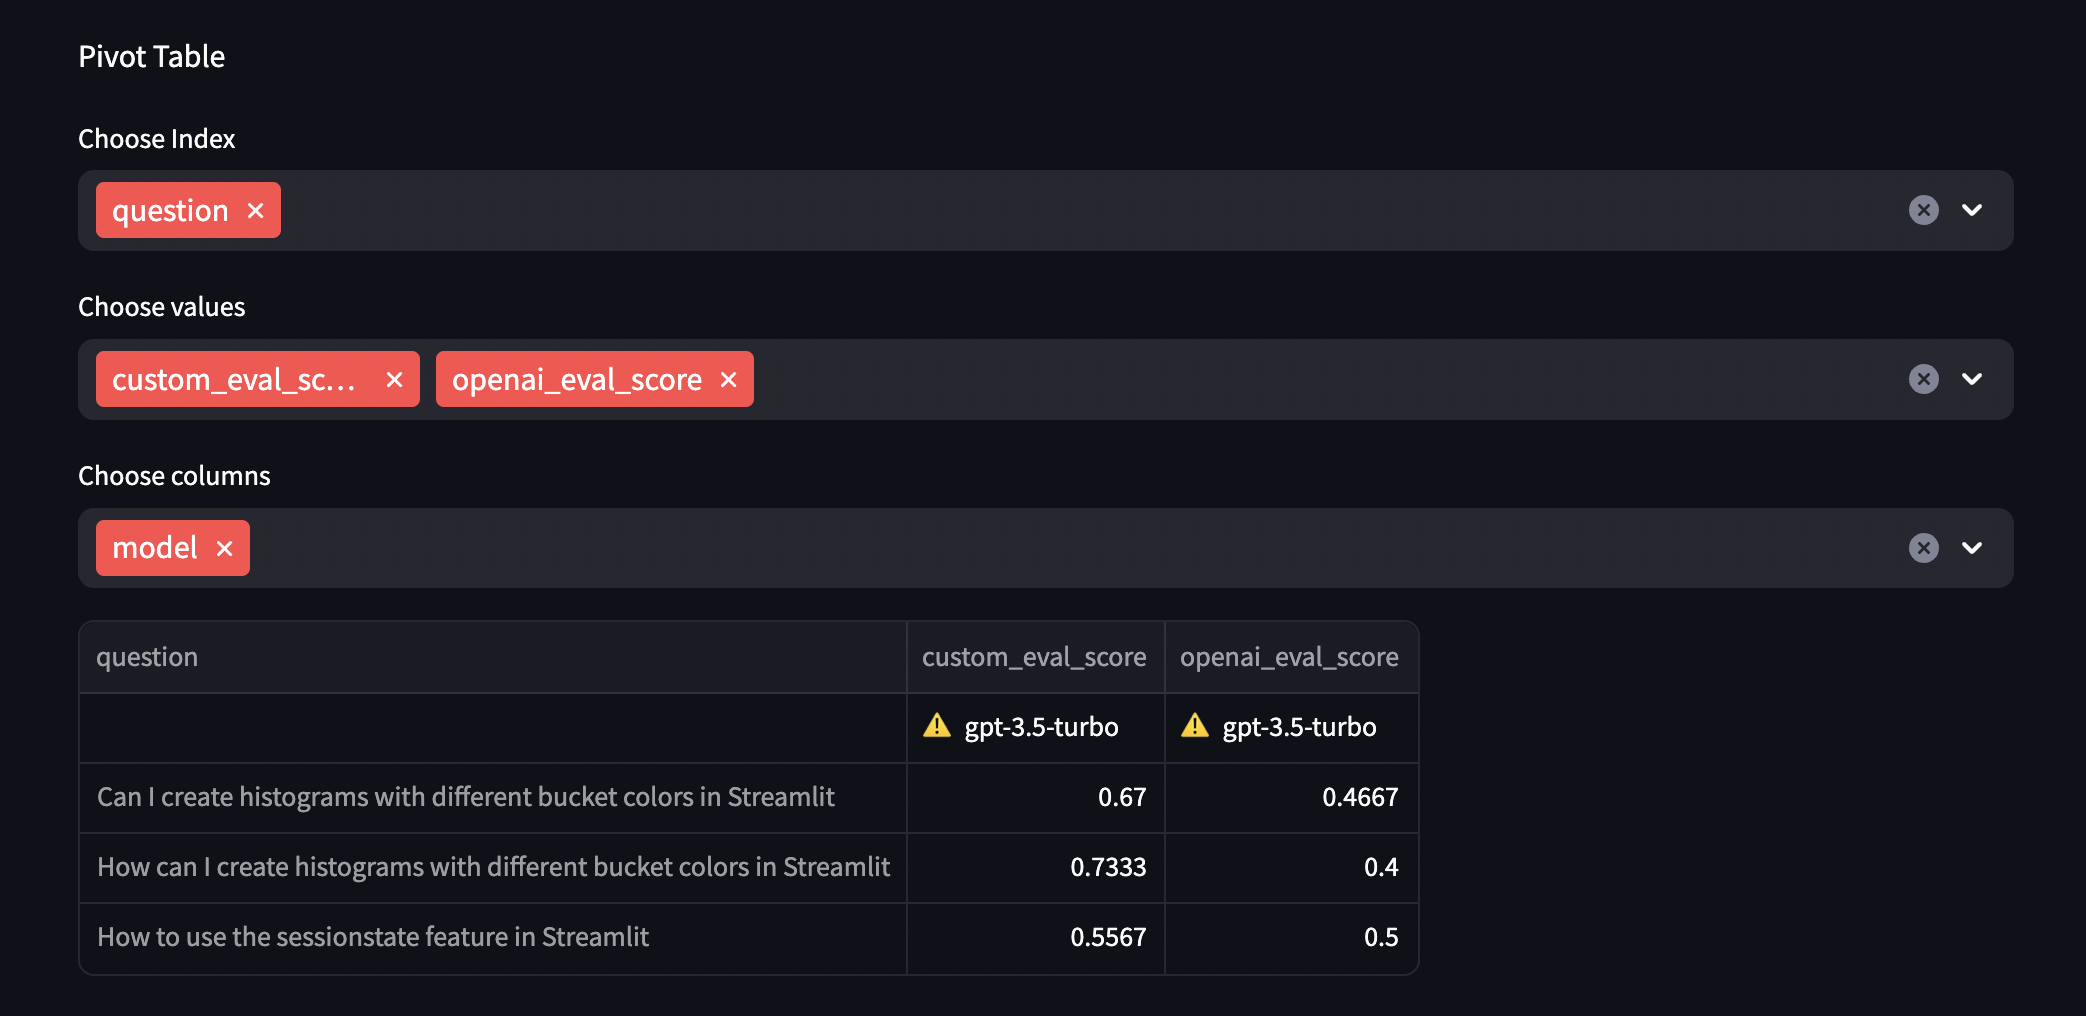